In [49]:
!pip install kaggle --quiet
!kaggle datasets download -d behrad3d/nasa-cmaps --quiet

Dataset URL: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
License(s): CC0-1.0


In [50]:
import zipfile, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define file paths
zip_path = "nasa-cmaps.zip"
extract_path = "nasa_cmaps_data"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to nasa_cmaps_data


In [51]:
os.listdir("nasa_cmaps_data")

['CMaps']

In [52]:

# Define file paths
train_file = os.path.join(extract_path, "CMaps/train_FD001.txt")
test_file = os.path.join(extract_path, "CMaps/test_FD001.txt")
rul_file = os.path.join(extract_path, "CMaps/RUL_FD001.txt")

# os.listdir(train_file)

In [53]:
train_data = pd.read_csv(train_file, sep=" ", header=None)
test_data = pd.read_csv(test_file, sep=" ", header=None)
rul_data = pd.read_csv(rul_file, sep=" ", header=None)

In [54]:
# Remove extra spaces and unnamed columns
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')
rul_data = rul_data.dropna(axis=1, how='all')

# Rename columns for clarity
columns = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

train_data.columns = columns
test_data.columns = columns
rul_data.columns = ['RUL']

In [55]:
# Check the structure and summary of the datasets
print("Train Data:")
print(train_data.head())
print(train_data.describe())

print("\nTest Data:")
print(test_data.head())
print(test_data.describe())

print("\nRUL Data:")
print(rul_data.head())
print(rul_data.describe())

# Check unique engine IDs
print(f"Number of engines in training set: {train_data['engine_id'].nunique()}")
print(f"Number of engines in test set: {test_data['engine_id'].nunique()}")

Train Data:
   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1       -0.0007       -0.0004         100.0    518.67   
1          1      2        0.0019       -0.0003         100.0    518.67   
2          1      3       -0.0043        0.0003         100.0    518.67   
3          1      4        0.0007        0.0000         100.0    518.67   
4          1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.0

In [56]:
# Add a 'time_to_failure' feature for training data
train_data['time_to_failure'] = train_data.groupby('engine_id')['cycle'].transform(max) - train_data['cycle']

# Rolling average for sensor measurements (example: 5-cycle window)
sensor_cols = [col for col in train_data.columns if 'sensor_' in col]
for col in sensor_cols:
    train_data[f'{col}_rolling_mean'] = train_data.groupby('engine_id')[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Repeat for test_data without using "time_to_failure"
for col in sensor_cols:
    test_data[f'{col}_rolling_mean'] = test_data.groupby('engine_id')[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())


<ipython-input-56-c7f399706d83>:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_data['time_to_failure'] = train_data.groupby('engine_id')['cycle'].transform(max) - train_data['cycle']


In [57]:
# Normalization or standardization is critical for ML models to handle multivariate data effectively.
from sklearn.preprocessing import MinMaxScaler

# Normalize sensor and operational settings
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[sensor_cols + ['op_setting_1', 'op_setting_2', 'op_setting_3']])
scaled_test = scaler.transform(test_data[sensor_cols + ['op_setting_1', 'op_setting_2', 'op_setting_3']])

# Add back to dataframes
train_data[sensor_cols + ['op_setting_1', 'op_setting_2', 'op_setting_3']] = scaled_train
test_data[sensor_cols + ['op_setting_1', 'op_setting_2', 'op_setting_3']] = scaled_test


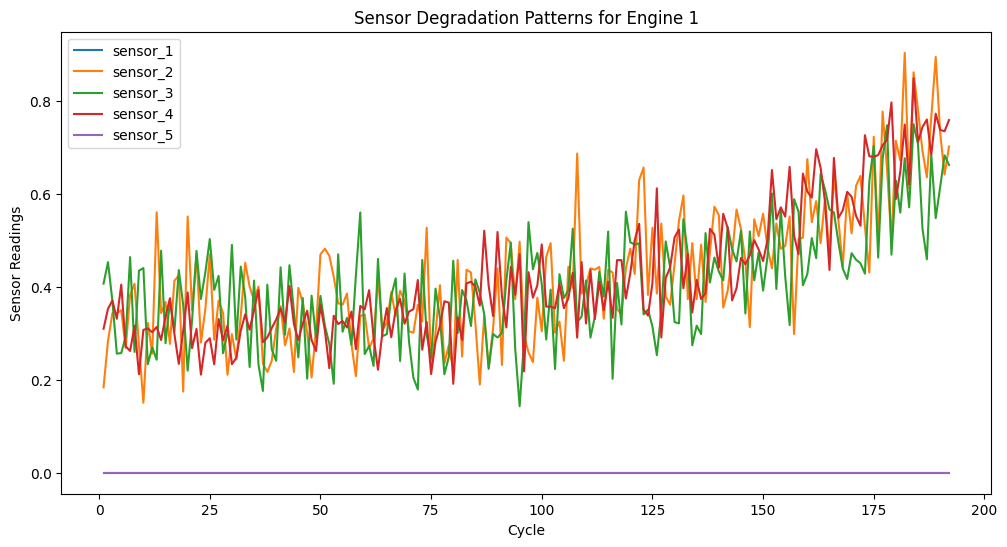

In [58]:
# Plot sensor readings and RUL to observe trend
# Example: Visualize sensor degradation patterns for an engine
engine_id = 1
engine_data = train_data[train_data['engine_id'] == engine_id]

plt.figure(figsize=(12, 6))
for col in sensor_cols[:5]:  # Plot the first 5 sensors for brevity
    plt.plot(engine_data['cycle'], engine_data[col], label=col)

plt.title(f"Sensor Degradation Patterns for Engine {engine_id}")
plt.xlabel("Cycle")
plt.ylabel("Sensor Readings")
plt.legend()
plt.show()

In [59]:
# Starting with a simple model, such as Random Forest, before moving to advanced models like LSTM.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [67]:
# Prepare training data
X = train_data[sensor_cols + ['op_setting_1', 'op_setting_2', 'op_setting_3']]
y = train_data['time_to_failure']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate on validation data
y_pred = rf.predict(X_val)
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_val, y_pred)))

print("Score ", rf.score(X_val, y_val))

Mean Absolute Error: 29.669462078992
Root Mean Squared Error: 41.50953624410164
Score  0.622867396724482
